In [1]:
import torch

PyTorch Tutorial: https://pytorch.org/tutorials/

In [3]:
import torch
torch.cuda.is_available()

True

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from tqdm import tqdm
from torch.optim import Adam

import math

In [7]:
# Model Hyperparameters

dataset_path = '~/datasets'

cuda = True
DEVICE = torch.device("cuda:0" if cuda else "cpu")

dataset = 'MNIST'
img_size = (32, 32, 3)   if dataset == "CIFAR10" else (28, 28, 1) # (width, height, channels)

timestep_embedding_dim = 256
n_layers = 8
hidden_dim = 256
n_timesteps = 1000
beta_minmax=[1e-4, 2e-2]

train_batch_size = 128
inference_batch_size = 64
lr = 5e-5
epochs = 20

seed = 1234

hidden_dims = [hidden_dim for _ in range(n_layers)]
torch.manual_seed(seed)
np.random.seed(seed)

<h2> Step 1. Load (or download) Dataset </h2>

- Pytorch offers domain-specific libraries such as **TorchText**, **TorchVision**, and **TorchAudio**.
- Pytorch has two primitives to work with data that allow to use pre-loaded datasets or own data: **torch.utils.data.DataLoader** and **torch.utils.data.Dataset**.
- Dataset stores the samples and their corresponding labels
- DataLoader wraps an iterable around the Dataset to enable easy access to samples

In [69]:
from torchvision.datasets import MNIST, CIFAR10 # torchvision.dataset module contains Dataset object for many real-world vision data like CIFAR and MNIST
import torchvision.transforms as transforms # to modify the samples
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# Define transform to ToTensor
transform = transforms.Compose([
        transforms.ToTensor(),
])

# Pass a variable number of keyword argument to a function or a method.
kwargs = {'num_workers': 1, 'pin_memory': True} 

if dataset == 'CIFAR10':
    train_dataset = CIFAR10(dataset_path, transform=transform, train=True, download=True)
    test_dataset  = CIFAR10(dataset_path, transform=transform, train=False, download=True)
else:
    train_dataset = MNIST(dataset_path, transform=transform, train=True, download=True)
    #train_dataset = MNIST(dataset_path, transform=ToTensor(), train=True, download=True)
    test_dataset  = MNIST(dataset_path, transform=transform, train=False, download=True)

# Pass the Dataset as an argument to DataLoader. 
# This wraps an iterable over the dataset, and support automatic batching, sampling, shuffling and multiprocess data loading.
train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=inference_batch_size, shuffle=False,  **kwargs)

# Batch_size specifies the number of samples processed before the model is updated. Smaller batch sizes can lead to better generalization.
# For this case, train_loader has lower batch_size than test_loader, why?

60000 10000
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0

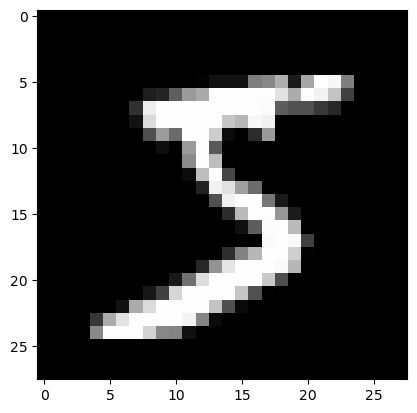

In [101]:
# Index the Datasets manually like a list: train_dataset[index]
print(len(train_dataset), len(test_dataset))
image, label = train_dataset[0]
print(image, label)
plt.imshow(image.squeeze(), cmap="gray")
plt.show()

In [113]:
print(type(image), type(label))
print(image.shape)
print(image.squeeze().shape)

<class 'torch.Tensor'> <class 'int'>
torch.Size([1, 28, 28])
torch.Size([28, 28])


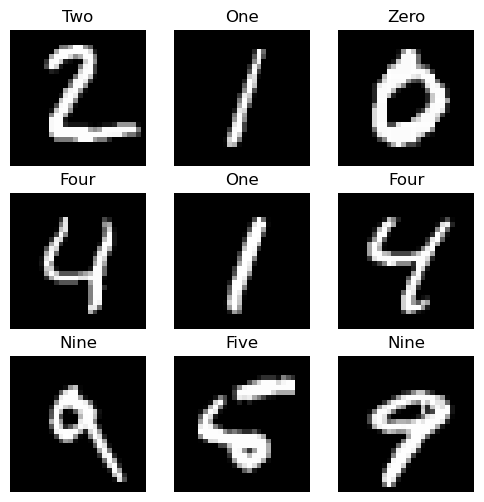

In [178]:
# Use Matplotlib to visualize some samples in the training/test data
labels_map = {
    0: "Zero",
    1: "One",
    2: "Two",
    3: "Three",
    4: "Four",
    5: "Five",
    6: "Six",
    7: "Seven",
    8: "Eight",
    9: "Nine",
}
figure = plt.figure(figsize=(6, 6))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_dataset), size=(1,)).item()
    #img, label = test_dataset[sample_idx]
    img, label = test_dataset[i]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [176]:
print(sample_idx)

3461


For Creating a custom dataset, check this link: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html 

Feature batch shape: torch.Size([128, 1, 28, 28])
Labels batch shape: torch.Size([128])


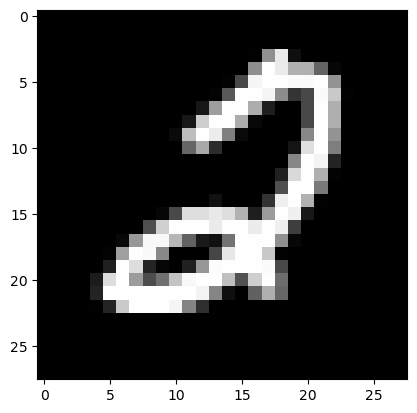

Label: 2


In [117]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


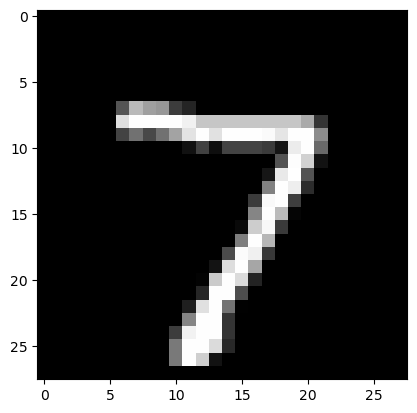

Label: 7


In [119]:
# Display image and label.
train_features, train_labels = next(iter(test_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

<h2>Step 2. Define our model: Denoising Diffusion Probabilistic Models (DDPMs) </h2> <br>
Sinusoidal embedding for diffusion timestep

In [123]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [125]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

Class Definition and Initialization:

- The **SinusoidalPosEmb** class inherits from nn.Module, indicating it is a neural network module.
- The __init__ method initializes the class with a single parameter dim, representing the dimension of the positional embeddings. <br>

Forward Method:

- **x.device** ensures the computation occurs on the same device (CPU or GPU) as the input tensor x.
- **half_dim** calculates half of the dimension dim, as the sinusoidal embedding will use both sine and cosine functions.
- **emb** calculates the positional embedding scaling factor using the logarithm of 10000 divided by half_dim - 1.
- **torch.exp** and **torch.arange** create a tensor of exponentially decreasing values.
- The input tensor **x** is then scaled by this positional embedding tensor.
- **emb.sin()** and **emb.cos()** apply sine and cosine functions to the scaled input, respectively.
- **torch.cat** concatenates the sine and cosine embeddings along the last dimension.
- The method returns the final positional embeddings.
This class generates sinusoidal positional embeddings for the input tensor, a common technique in transformer models and diffusion models to incorporate position information into the model.

<h2> In this tutorial, we use a simple stacked-convolution model with various dilations instead of UNet-like architecture. </h2>

In [127]:
class ConvBlock(nn.Conv2d):
    """
        Conv2D Block
            Args:
                x: (N, C_in, H, W)
            Returns:
                y: (N, C_out, H, W)
    """

    def __init__(self, in_channels, out_channels, kernel_size, activation_fn=None, drop_rate=0.,
                    stride=1, padding='same', dilation=1, groups=1, bias=True, gn=False, gn_groups=8):
        
        if padding == 'same':
            padding = kernel_size // 2 * dilation

        super(ConvBlock, self).__init__(in_channels, out_channels, kernel_size,
                                            stride=stride, padding=padding, dilation=dilation,
                                            groups=groups, bias=bias)

        self.activation_fn = nn.SiLU() if activation_fn else None
        self.group_norm = nn.GroupNorm(gn_groups, out_channels) if gn else None
        
    def forward(self, x, time_embedding=None, residual=False):
        
        if residual:
            # in the paper, diffusion timestep embedding was only applied to residual blocks of U-Net
            x = x + time_embedding
            y = x
            x = super(ConvBlock, self).forward(x)
            y = y + x
        else:
            y = super(ConvBlock, self).forward(x)
        y = self.group_norm(y) if self.group_norm is not None else y
        y = self.activation_fn(y) if self.activation_fn is not None else y
        
        return y

**ConvBlock Class**
The ConvBlock class extends nn.Conv2d and defines a convolutional block with optional activation and normalization.

1. **Initialization** (__init__ Method):

- Padding Calculation - If padding is set to 'same', it adjusts the padding to ensure the output has the same spatial dimensions as the input.
- Super Initialization - Calls the __init__ method of nn.Conv2d with the provided parameters, initializing the convolution layer.
- Activation Function - If activation_fn is provided, it defaults to nn.SiLU (Swish activation function).
- Group Normalization - If gn (group normalization) is enabled, it initializes nn.GroupNorm with the specified number of groups.

2. **Forward Method**:

- Residual Connection - If residual is True, the input tensor x is added to the time_embedding, then the output y is computed by adding the original x and the convolution output.
- Normal Convolution - If residual is False, it performs a standard convolution.
Group Normalization - Applies group normalization if it is initialized.
- Activation Function - Applies the activation function if it is initialized.
- Return - Outputs the final tensor after applying convolution, optional group normalization, and optional activation function. <br>


The ConvBlock class provides a flexible convolutional block with options for activation functions, group normalization, and residual connections, suitable for use in neural network architectures like U-Net.

In [129]:
class Denoiser(nn.Module):
    
    def __init__(self, image_resolution, hidden_dims=[256, 256], diffusion_time_embedding_dim = 256, n_times=1000):
        super(Denoiser, self).__init__()
        
        _, _, img_C = image_resolution
        
        self.time_embedding = SinusoidalPosEmb(diffusion_time_embedding_dim)
        
        self.in_project = ConvBlock(img_C, hidden_dims[0], kernel_size=7)
        
        self.time_project = nn.Sequential(
                                 ConvBlock(diffusion_time_embedding_dim, hidden_dims[0], kernel_size=1, activation_fn=True),
                                 ConvBlock(hidden_dims[0], hidden_dims[0], kernel_size=1))
        
        self.convs = nn.ModuleList([ConvBlock(in_channels=hidden_dims[0], out_channels=hidden_dims[0], kernel_size=3)])
        
        for idx in range(1, len(hidden_dims)):
            self.convs.append(ConvBlock(hidden_dims[idx-1], hidden_dims[idx], kernel_size=3, dilation=3**((idx-1)//2),
                                                    activation_fn=True, gn=True, gn_groups=8))                                
                               
        self.out_project = ConvBlock(hidden_dims[-1], out_channels=img_C, kernel_size=3)
        
        
    def forward(self, perturbed_x, diffusion_timestep):
        y = perturbed_x
        
        diffusion_embedding = self.time_embedding(diffusion_timestep)
        diffusion_embedding = self.time_project(diffusion_embedding.unsqueeze(-1).unsqueeze(-2))
        
        y = self.in_project(y)
        
        for i in range(len(self.convs)):
            y = self.convs[i](y, diffusion_embedding, residual = True)
            
        y = self.out_project(y)
            
        return y
    
model = Denoiser(image_resolution=img_size,
                 hidden_dims=hidden_dims, 
                 diffusion_time_embedding_dim=timestep_embedding_dim, 
                 n_times=n_timesteps).to(DEVICE)

**Denoiser Class**

The Denoiser class extends nn.Module and defines a neural network for denoising images, which includes components for processing both the input images and the diffusion time steps.

1. **Initialization** (__init__ Method):

- Time Embedding - Initializes SinusoidalPosEmb to encode diffusion time steps into a higher-dimensional space.
- Input Projection - Uses ConvBlock to project the input image channels to the first hidden dimension.
- Time Step Projection - A sequential model with two ConvBlocks that project the diffusion time embedding to match the hidden dimensions.
- Convolutional Layers (convs) - Initializes a list of ConvBlocks with increasing dilation rates and optional activation and group normalization.
- Output Projection - Uses ConvBlock to project the final hidden dimension back to the original image channels.

2. **Forward Method**:

- Time Embedding - Applies the sinusoidal positional embedding to the diffusion time steps and processes it through time_project.
- Input Processing - Projects the input perturbed image perturbed_x through in_project.
- Convolutional Layers with Residual Connections - Iterates through convs, applying each convolution block to the input and adding the time embedding, using residual connections.
- Output Projection - Projects the final processed tensor back to the original image channels using out_project.

3. **Model Instantiation**:

- Creates an instance of the Denoiser model with the specified parameters for image resolution, hidden dimensions, diffusion time embedding dimension, and number of time steps, then moves it to the specified device (DEVICE).


The Denoiser class is designed to handle the denoising of images in the context of a diffusion model, effectively processing both image and diffusion time step information through a series of convolutional operations with optional residual connections and normalization.

<h3> Define Gaussian Diffusion </h3>

In [131]:
class Diffusion(nn.Module):
    def __init__(self, model, image_resolution=[32, 32, 3], n_times=1000, beta_minmax=[1e-4, 2e-2], device='cuda'):
    
        super(Diffusion, self).__init__()
    
        self.n_times = n_times
        self.img_H, self.img_W, self.img_C = image_resolution

        self.model = model
        
        # define linear variance schedule(betas)
        beta_1, beta_T = beta_minmax
        betas = torch.linspace(start=beta_1, end=beta_T, steps=n_times).to(device) # follows DDPM paper
        self.sqrt_betas = torch.sqrt(betas)
                                     
        # define alpha for forward diffusion kernel
        self.alphas = 1 - betas
        self.sqrt_alphas = torch.sqrt(self.alphas)
        alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1-alpha_bars)
        self.sqrt_alpha_bars = torch.sqrt(alpha_bars)
        
        self.device = device
    
    def extract(self, a, t, x_shape):
        """
            from lucidrains' implementation
                https://github.com/lucidrains/denoising-diffusion-pytorch/blob/beb2f2d8dd9b4f2bd5be4719f37082fe061ee450/denoising_diffusion_pytorch/denoising_diffusion_pytorch.py#L376
        """
        b, *_ = t.shape
        out = a.gather(-1, t)
        return out.reshape(b, *((1,) * (len(x_shape) - 1)))
    
    def scale_to_minus_one_to_one(self, x):
        # according to the DDPMs paper, normalization seems to be crucial to train reverse process network
        return x * 2 - 1
    
    def reverse_scale_to_zero_to_one(self, x):
        return (x + 1) * 0.5
    
    def make_noisy(self, x_zeros, t): 
        # perturb x_0 into x_t (i.e., take x_0 samples into forward diffusion kernels)
        epsilon = torch.randn_like(x_zeros).to(self.device)
        
        sqrt_alpha_bar = self.extract(self.sqrt_alpha_bars, t, x_zeros.shape)
        sqrt_one_minus_alpha_bar = self.extract(self.sqrt_one_minus_alpha_bars, t, x_zeros.shape)
        
        # Let's make noisy sample!: i.e., Forward process with fixed variance schedule
        #      i.e., sqrt(alpha_bar_t) * x_zero + sqrt(1-alpha_bar_t) * epsilon
        noisy_sample = x_zeros * sqrt_alpha_bar + epsilon * sqrt_one_minus_alpha_bar
    
        return noisy_sample.detach(), epsilon
    
    
    def forward(self, x_zeros):
        x_zeros = self.scale_to_minus_one_to_one(x_zeros)
        
        B, _, _, _ = x_zeros.shape
        
        # (1) randomly choose diffusion time-step
        t = torch.randint(low=0, high=self.n_times, size=(B,)).long().to(self.device)
        
        # (2) forward diffusion process: perturb x_zeros with fixed variance schedule
        perturbed_images, epsilon = self.make_noisy(x_zeros, t)
        
        # (3) predict epsilon(noise) given perturbed data at diffusion-timestep t.
        pred_epsilon = self.model(perturbed_images, t)
        
        return perturbed_images, epsilon, pred_epsilon
    
    
    def denoise_at_t(self, x_t, timestep, t):
        B, _, _, _ = x_t.shape 
        if t > 1:
            z = torch.randn_like(x_t).to(self.device)
        else:
            z = torch.zeros_like(x_t).to(self.device)
        
        # at inference, we use predicted noise(epsilon) to restore perturbed data sample.
        epsilon_pred = self.model(x_t, timestep)
        
        alpha = self.extract(self.alphas, timestep, x_t.shape)
        sqrt_alpha = self.extract(self.sqrt_alphas, timestep, x_t.shape)
        sqrt_one_minus_alpha_bar = self.extract(self.sqrt_one_minus_alpha_bars, timestep, x_t.shape)
        sqrt_beta = self.extract(self.sqrt_betas, timestep, x_t.shape)
        
        # denoise at time t, utilizing predicted noise
        x_t_minus_1 = 1 / sqrt_alpha * (x_t - (1-alpha)/sqrt_one_minus_alpha_bar*epsilon_pred) + sqrt_beta*z
        
        return x_t_minus_1.clamp(-1., 1)
                
    def sample(self, N):
        # start from random noise vector, x_0 (for simplicity, x_T declared as x_t instead of x_T)
        x_t = torch.randn((N, self.img_C, self.img_H, self.img_W)).to(self.device)
        
        # autoregressively denoise from x_T to x_0
        #     i.e., generate image from noise, x_T
        for t in range(self.n_times-1, -1, -1):
            timestep = torch.tensor([t]).repeat_interleave(N, dim=0).long().to(self.device)
            x_t = self.denoise_at_t(x_t, timestep, t)
        
        # denormalize x_0 into 0 ~ 1 ranged values.
        x_0 = self.reverse_scale_to_zero_to_one(x_t)
        
        return x_0
    
    
diffusion = Diffusion(model, image_resolution=img_size, n_times=n_timesteps, 
                      beta_minmax=beta_minmax, device=DEVICE).to(DEVICE)

optimizer = Adam(diffusion.parameters(), lr=lr)
denoising_loss = nn.MSELoss()

**Diffusion Class**

The Diffusion class extends nn.Module and encapsulates the functionality of the diffusion model, which includes both the forward and reverse diffusion processes.

1. Initialization (__init__ Method):

- Variance Schedule - Defines a linear variance schedule (betas) for the forward diffusion process, which is crucial for the noise addition process.
- Alpha Calculation - Computes alphas and related terms (sqrt_alphas, sqrt_one_minus_alpha_bars, sqrt_alpha_bars) for the forward diffusion process, essential for both the forward and reverse processes.
- Model - Assigns the neural network model for predicting the noise (epsilon).

2. Noise Addition (**make_noisy** Method):

- Perturbs the input images (x_zeros) into noisy samples (x_t) by combining the input with a noise term (epsilon) according to the variance schedule.

3. Forward Method (**forward** Method):

- Scales input images to the range [-1, 1].
- Randomly selects diffusion time steps (t).
- Applies the forward diffusion process to create noisy images.
- Uses the model to predict the noise (epsilon) from the noisy images.

4. Denoising at Specific Timestep (**denoise_at_t** Method):

- Denoises the image at a specific time step (timestep) using the predicted noise.
- Utilizes the precomputed alphas and betas to progressively reduce noise from the perturbed images, eventually reconstructing the original image.

5. Image Sampling (**sample** Method):

- Starts with random noise and autoregressively denoises it step by step to generate an image.
- The generated image is scaled back to the range [0, 1].

6. Model Instantiation and Training Setup:

- Creates an instance of the Diffusion model with specified parameters.
- Initializes an optimizer (Adam) and a loss function (nn.MSELoss) for training the diffusion model.

The Diffusion class effectively combines the components necessary for both forward and reverse processes in a denoising diffusion probabilistic model, allowing for the generation of images from random noise and the training of the model to predict noise accurately.

In [133]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of model parameters: ", count_parameters(diffusion))

Number of model parameters:  4870913


<h3> Visualizing forward process </h3>

In [135]:
model.eval()
for batch_idx, (x, _) in enumerate(test_loader):
    x = x.to(DEVICE)
    perturbed_images, epsilon, pred_epsilon = diffusion(x)
    perturbed_images = diffusion.reverse_scale_to_zero_to_one(perturbed_images)
    break

In [145]:
type(x)

torch.Tensor

In [147]:
x.shape

torch.Size([64, 1, 28, 28])

In [153]:
print(type(perturbed_images), type(epsilon), type(pred_epsilon))

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


In [155]:
print(perturbed_images.shape, epsilon.shape, pred_epsilon.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])


In [137]:
def show_image(x, idx):
    fig = plt.figure()
    plt.imshow(x[idx].transpose(0, 1).transpose(1, 2).detach().cpu().numpy())

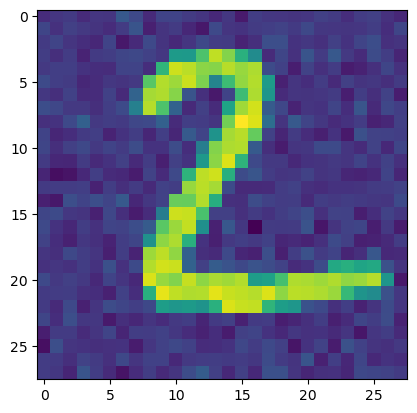

In [172]:
show_image(perturbed_images, idx=1)

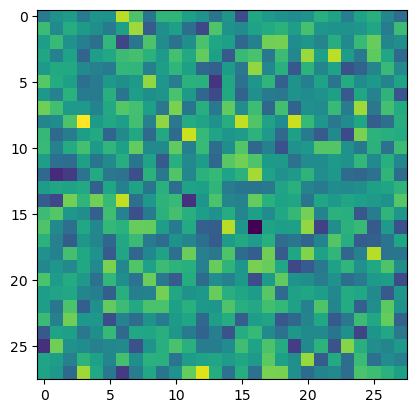

In [39]:
show_image(perturbed_images, idx=1)

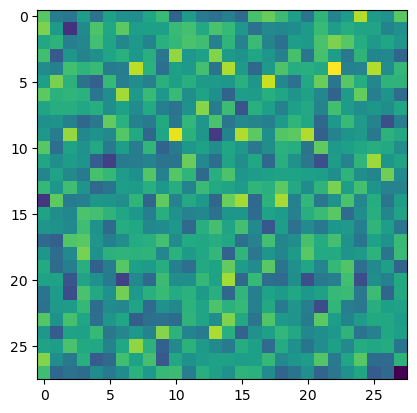

In [41]:
show_image(perturbed_images, idx=2)

<h2> Step 3. Train Denoising Diffusion Probabilistic Models(DDPMs) </h2>

In [47]:
print("Start training DDPMs...")
model.train()

for epoch in range(epochs):
    noise_prediction_loss = 0
    for batch_idx, (x, _) in tqdm(enumerate(train_loader), total=len(train_loader)):
        optimizer.zero_grad()

        x = x.to(DEVICE)
        
        noisy_input, epsilon, pred_epsilon = diffusion(x)
        loss = denoising_loss(pred_epsilon, epsilon)
        
        noise_prediction_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tDenoising Loss: ", noise_prediction_loss / batch_idx)
    
print("Finish!!")

Start training DDPMs...


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [02:36<00:00,  3.00it/s]


	Epoch 1 complete! 	Denoising Loss:  0.027306088755846534


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [02:37<00:00,  2.98it/s]


	Epoch 2 complete! 	Denoising Loss:  0.026915239170193672


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [02:36<00:00,  2.99it/s]


	Epoch 3 complete! 	Denoising Loss:  0.02657579331714501


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [02:37<00:00,  2.99it/s]


	Epoch 4 complete! 	Denoising Loss:  0.02672068323366917


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [02:36<00:00,  2.99it/s]


	Epoch 5 complete! 	Denoising Loss:  0.026190492826012466


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [02:36<00:00,  3.00it/s]


	Epoch 6 complete! 	Denoising Loss:  0.026304559145345647


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [02:36<00:00,  3.00it/s]


	Epoch 7 complete! 	Denoising Loss:  0.026134012071972985


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [02:36<00:00,  2.99it/s]


	Epoch 8 complete! 	Denoising Loss:  0.025656311128001947


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [02:37<00:00,  2.97it/s]


	Epoch 9 complete! 	Denoising Loss:  0.02581367263984349


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [02:36<00:00,  2.99it/s]


	Epoch 10 complete! 	Denoising Loss:  0.025526813975670654


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [02:37<00:00,  2.98it/s]


	Epoch 11 complete! 	Denoising Loss:  0.025258024473889515


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [02:37<00:00,  2.98it/s]


	Epoch 12 complete! 	Denoising Loss:  0.02530524665171392


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [02:36<00:00,  2.99it/s]


	Epoch 13 complete! 	Denoising Loss:  0.02547669909400945


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [02:36<00:00,  3.00it/s]


	Epoch 14 complete! 	Denoising Loss:  0.025074115369277887


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [02:35<00:00,  3.01it/s]


	Epoch 15 complete! 	Denoising Loss:  0.025174077942521654


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [02:35<00:00,  3.01it/s]


	Epoch 16 complete! 	Denoising Loss:  0.025057677497975845


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [02:35<00:00,  3.01it/s]


	Epoch 17 complete! 	Denoising Loss:  0.024873753818563927


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [02:35<00:00,  3.01it/s]


	Epoch 18 complete! 	Denoising Loss:  0.024947189793595646


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [02:35<00:00,  3.01it/s]


	Epoch 19 complete! 	Denoising Loss:  0.024652207457325142


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [02:35<00:00,  3.01it/s]

	Epoch 20 complete! 	Denoising Loss:  0.02459430892386625
Finish!!


<h2> Step 4. Sample images from noise. </h2>

In [160]:
model.eval()

with torch.no_grad():
    generated_images = diffusion.sample(N=inference_batch_size)

In [162]:
generated_images.shape

torch.Size([64, 1, 28, 28])

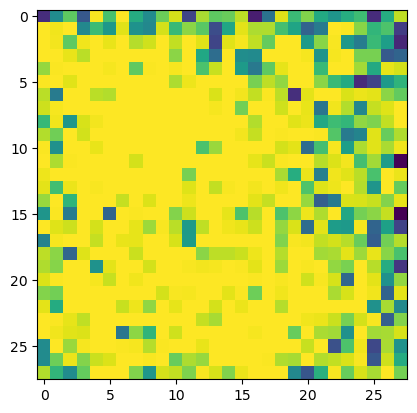

In [164]:
show_image(generated_images, idx=0)

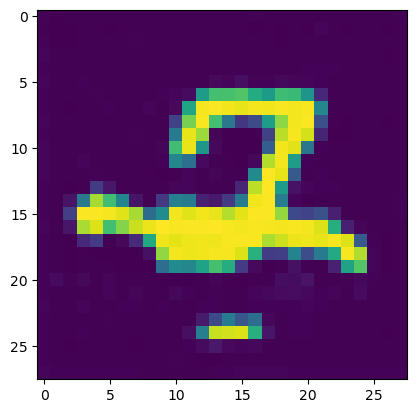

In [53]:
show_image(generated_images, idx=0)

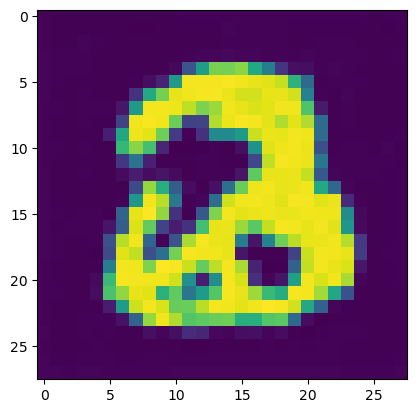

In [55]:
show_image(generated_images, idx=1)

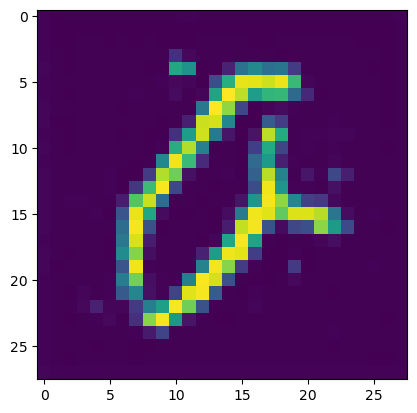

In [57]:
show_image(generated_images, idx=2)

<h2> Comparison with ground-truth samples </h2>

In [168]:
def draw_sample_image(x, postfix):
  
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

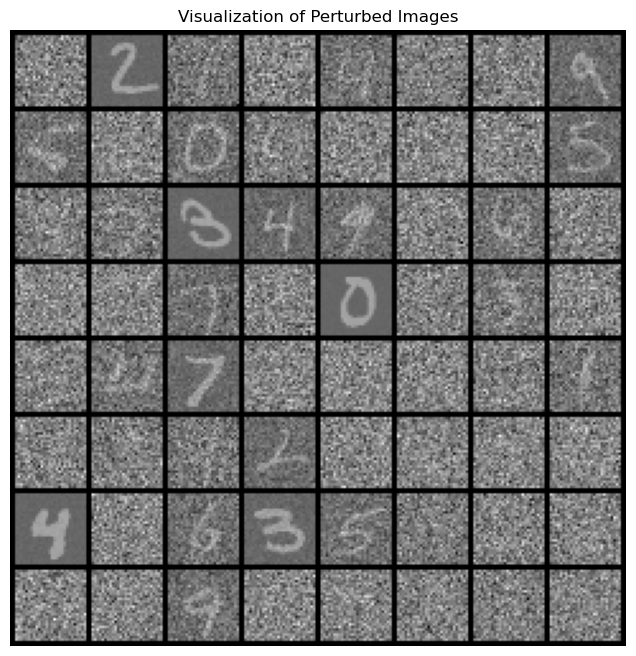

In [170]:
draw_sample_image(perturbed_images, "Perturbed Images")

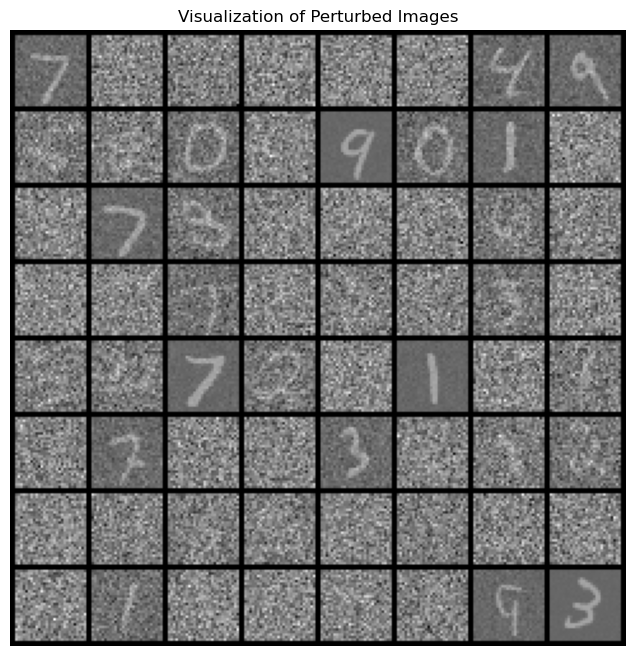

In [62]:
draw_sample_image(perturbed_images, "Perturbed Images")

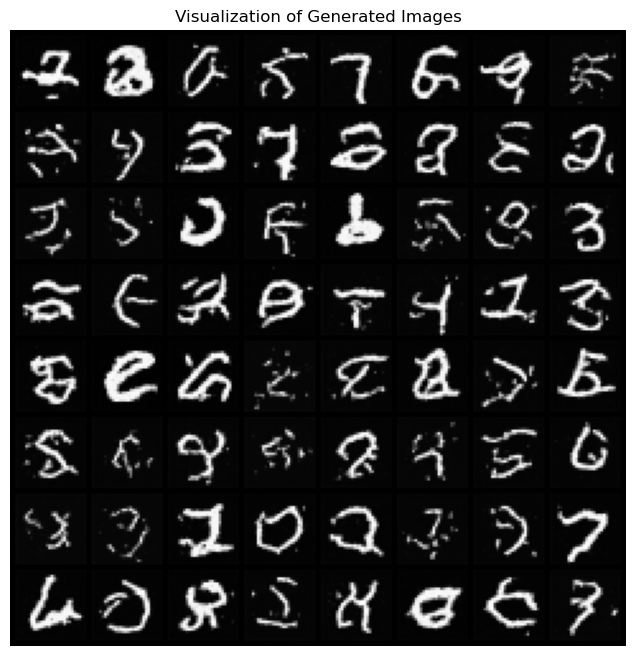

In [64]:
draw_sample_image(generated_images, "Generated Images")

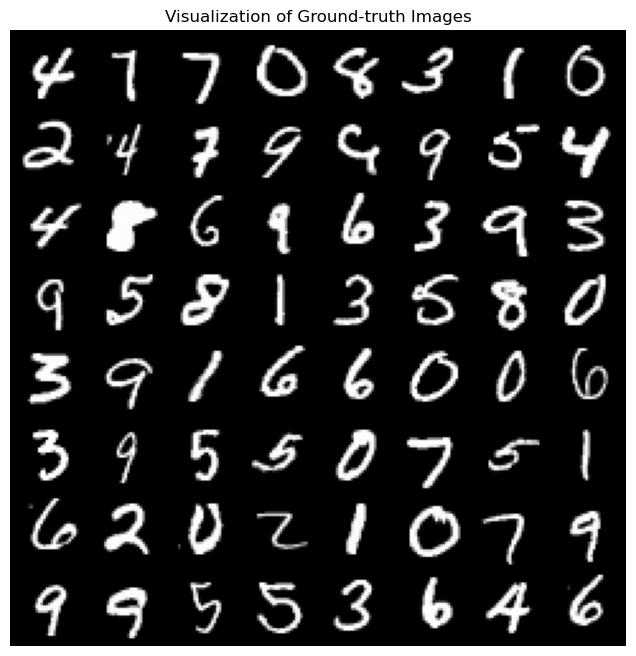

In [66]:
draw_sample_image(x[:inference_batch_size], "Ground-truth Images")